# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
MODEL_DIR = BASE_DIR + 'models/'
PRED_DIR = BASE_DIR + 'predictions/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


Mounted at /content/gdrive


# Imports
____________________

In [ ]:
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import nltk
import string
import re
import io
from tensorflow import keras, random
from tensorflow.keras import layers, regularizers, callbacks, metrics, initializers
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Input, Concatenate, Flatten, Dropout, SpatialDropout1D, LSTM, GRU, Bidirectional, GlobalAvgPool1D, GlobalMaxPool1D
from keras.models import Model, load_model, save_model
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
# custom imports
from utils import getComments, train_val_split
from preprocessing import Preprocessor
from embeddings import load_glove_vectors, load_fasttext_vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setup

In [ ]:
### SETTINGS ###
settings = {
      'RANDOM_STATE': 42,
      'EMBEDDING_CHOICE': 'fasttext', # 'fasttext', 'glove'
      'SOURCES': ['de', 'fr', 'es'], # ['de', 'fr', 'es', 'syn_0', 'syn_1', 'syn_2'], use [] to keep only original data 
      'TEST_SIZE': 0.2,
      'UNDERSAMPLE': False
}
# set seeds
seed(settings['RANDOM_STATE'])
random.set_seed(settings['RANDOM_STATE'])
# shortcut
labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate', 'is_toxic']

# Load data
____________________

In [ ]:
# load train
if settings['UNDERSAMPLE']:
  train = pd.read_csv(DATA_DIR + 'train_aug_und_cleaned.csv', sep='\t')
else:
  train = pd.read_csv(DATA_DIR + 'train_aug_cleaned.csv', sep='\t')

# load test
test = pd.read_csv(DATA_DIR + 'test_cleaned.csv', sep='\t')

# load test labels
test_labels = pd.read_csv(DATA_DIR + 'test_labels_cleaned.csv', sep='\t')

# Prepare test data for model inputs
____________________

## Binary model

In [ ]:
# instantiate Preprocessor object
p_1 = Preprocessor(path_to_tokenizer=TOKENIZER_DIR + 'fitted_binary_tokenizer_lstm')

In [ ]:
X_test_1 = test['comment_text']
y_test_1 = test_labels['is_toxic']
# transform test comments to sequences
X_test_1 = p_1.toSequences(X_test_1)

## Multilabel model

In [ ]:
# instantiate Preprocessor object
p_2 = Preprocessor(path_to_tokenizer=TOKENIZER_DIR + 'fitted_multilabel_tokenizer_lstm')

In [ ]:
X_test_2 = test['comment_text']
y_test_2 = test_labels[labels]
# transform test comments to sequences
X_test_2 = p_2.toSequences(X_test_2)

# utils

In [ ]:
def saveWordIndexes(tokenizer):
  with open(base_dir + 'saved_model/word_index.json', 'w') as fp:
    json.dump(tokenizer.word_index, fp)

def plotHistory(history, metrics, title):
  plt.title(title)
  plt.plot(history.history[metrics[0]])
  plt.plot(history.history[metrics[1]])
  plt.ylabel(metrics[0])
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

def plot_roc(y_test, y_score):
  # plot settings
  lw = 2
  figure(figsize=(10,8))
  num_classes = 6
  y_test = np.array(y_test)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(num_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= num_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[i]))
  
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multilabel ROC CURVE')
  plt.legend(loc="lower right")
  plt.show()

def print_confusion_matrix(y_true, y_pred):
  i = 0
  for cm in multilabel_confusion_matrix(y_true, y_pred, samplewise=False):
    print('###################')
    print(labels[i])
    print(cm)
    i = i+1

# Binary classification
____________________

## Load model

In [ ]:
model_binary = load_model(MODEL_DIR + 'lstm_bin.h5')


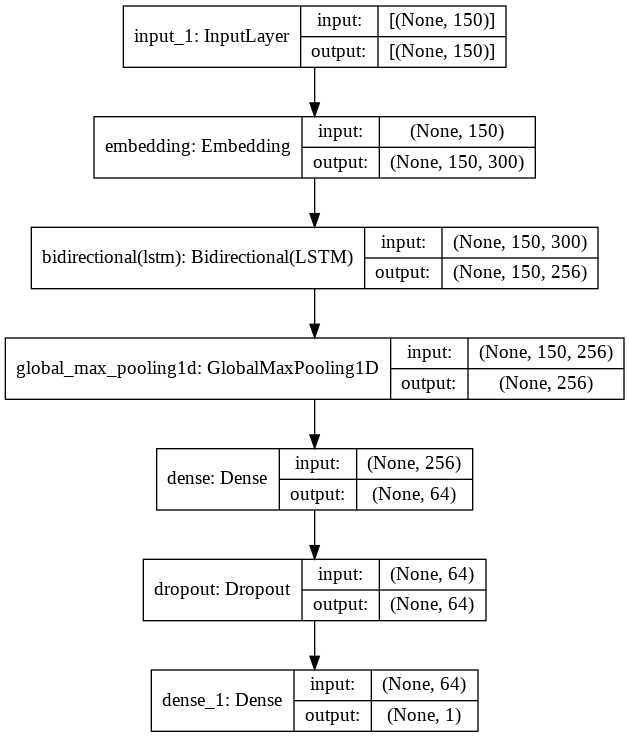

In [ ]:
plot_model(model_binary, show_shapes=True)

## Predict test

Make predictions on the test set

In [ ]:
y_scores_binary = model_binary.predict(X_test_1)

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_binary = [[1 if label >= threshold else 0 for label in score] for score in y_scores_binary]

In [ ]:
confusion_matrix(y_test_1, y_pred_binary)

array([[51257,  6018],
       [  551,  5691]])

# Filter results for the multilabel classification

Prepare test set for the 2nd phase: the comments that have been classified as not toxic by the binary model will not be considered in the multilabel classification.

In [ ]:
# create final dataframe for merging results
# negative values means that needs 2nd model predictions
y_final = pd.DataFrame(np.repeat(y_pred_binary, 6, 1)*-1, columns=labels)

In [ ]:
# save false positive to analyze what's wrong
indexes = test_labels[test_labels['is_toxic']==0].index
fp = y_final.loc[indexes,:]
fp = fp[fp['toxic']==-1]
print('# false positives:', len(fp))
fp.to_csv(DATA_DIR + 'false_positives_1.csv', index=True, index_label='index')

# false positives: 6018


In [ ]:
# filter test set to values that need predictions
y_test_2 = y_final[y_final['toxic']==-1]
# assign true labels
y_test_2 = test_labels.loc[y_test_2.index, labels] #######
# remove comments predicted not toxic during the 1st phase
indexes = y_final[y_final['toxic']==0].index
X_test_2 = np.delete(X_test_2, indexes, axis=0)


# Multilabel classification
____________________

## Load model

In [ ]:
model_multi = load_model(MODEL_DIR + 'lstm_multi.h5')

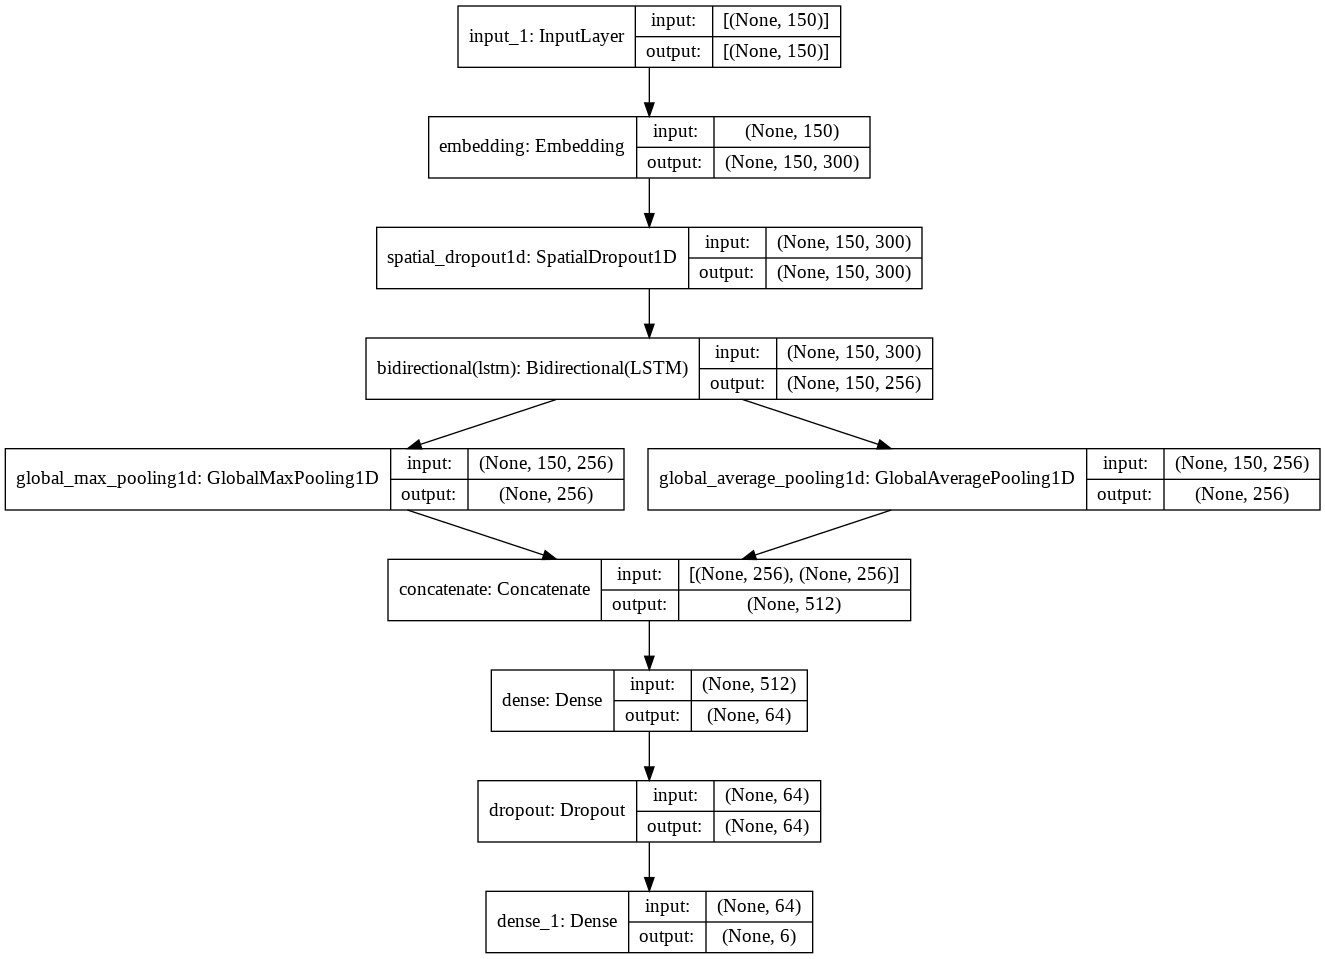

In [ ]:
plot_model(model_multi, show_shapes=True)

## Predict test

Make predictions on the test set

In [ ]:
y_score_multi = model_multi.predict(X_test_2)

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_multi = [[1 if label >= threshold else 0 for label in score] for score in y_score_multi]

# Merge final predictions

In [ ]:
# predictions
y_pred = pd.DataFrame.copy(y_final)
y_pred[y_pred['toxic']==-1] = y_pred_multi

# true labels
y_test = test_labels[labels]

## Final evaluation

Measure the performance of the combined models

In [ ]:
print('Precision:', round(precision_score(y_test, y_pred, average='macro'), 5))
print('Recall:', round(recall_score(y_test, y_pred, average='macro'), 5))
print('F1 score:', round(f1_score(y_test, y_pred, average='macro'), 5))
print_confusion_matrix(y_test, y_pred)

Precision: 0.40796
Recall: 0.6875
F1 score: 0.51018
###################
toxic
[[51536  5892]
 [  604  5485]]
###################
severe_toxic
[[62559   591]
 [  168   199]]
###################
obscene
[[56648  3179]
 [  619  3071]]
###################
threat
[[63082   224]
 [  101   110]]
###################
insult
[[57296  2795]
 [  896  2530]]
###################
identity_hate
[[62220   585]
 [  292   420]]


## Save predictions

In [ ]:
# save predictions
y_pred = pd.DataFrame(y_pred, columns=labels)
y_pred.to_csv(PRED_DIR + 'best_2_phases.csv', index=False, sep='\t')